In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we will use **ResNet** architecture (adapted for small images, like $32 \times 32$ images) for classifying images from CIFAR10 dataset.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<br/>
    <img src='../images/cifar_data.png' width=50% height=50% />
<br/>

### Loading CIFAR10 dataset into train-val-test set

In [1]:
import torchvision.transforms as transforms 
import torchvision.datasets as datasets

**train-test-transform**

In [2]:
# Define a transform to normalize the data
train_transform = transforms.Compose([transforms.RandomResizedCrop((32, 32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)

# val-dataset refers to the same dataset as train-dataset, however, while validating the model's performance
# we do not use any random-transformation
val_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=test_transform)

test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Separating train-set into train & validation set**
- Let's set validation set size as 20%, therefore, we will be using 80% of training set for training 
    the neural network
- Validating a model while training w.r.t a validation-set can help us from overfitting
- Validation-set works as an alternative to the actual test-set, as it is assumed that while training 
    we do not have any access to the test-set 

In [4]:
train_set_size = len(train_dataset)
print('train-set-size: {}'.format(train_set_size))

train-set-size: 50000


In [5]:
import numpy as np

all_indices = list(range(train_set_size))
print('len(all_indices): '.format(len(all_indices)))

np.random.shuffle(all_indices)

val_size = int(0.2 * len(all_indices))
train_size = len(all_indices) - val_size
print('val-size: {} train-size: {}'.format(val_size, train_size))

val_indices = all_indices[:val_size]
train_indices = all_indices[val_size:]

print('len(train_indices): {} len(val_indices): {}'.format(len(train_indices), len(val_indices)))

len(all_indices): 
val-size: 10000 train-size: 40000
len(train_indices): 40000 len(val_indices): 10000


In [6]:
from torch.utils.data import SubsetRandomSampler
import torch

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                           sampler=SubsetRandomSampler(train_indices), num_workers=4, 
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                        sampler=SubsetRandomSampler(val_indices), num_workers=4,
                                        pin_memory=True)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,
                                          num_workers=4, pin_memory=True)

In [8]:
train_data, train_targets = next(iter(train_loader))
val_data, val_targets = next(iter(val_loader))
test_data, test_targets = next(iter(test_loader))

In [9]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
import matplotlib.pyplot as plt

### Visualize a Batch of Training Data

In [11]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

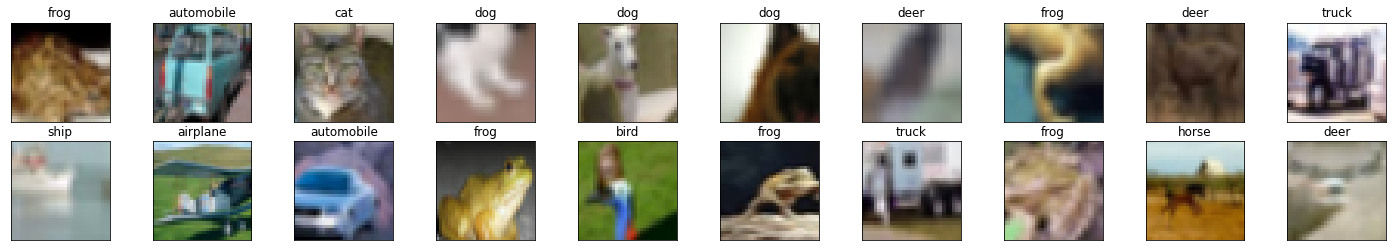

In [12]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(train_data[idx])
    ax.set_title(classes[train_targets[idx]])

### Visualize a Batch of Validation Data

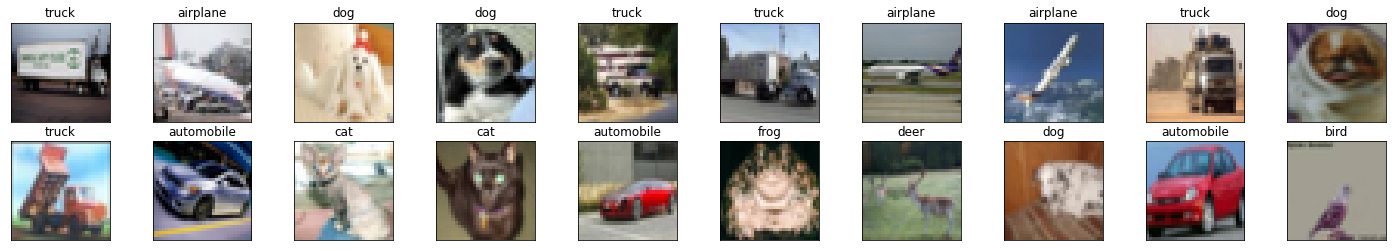

In [13]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(val_data[idx])
    ax.set_title(classes[val_targets[idx]])

### Visualize a Batch of Test Data

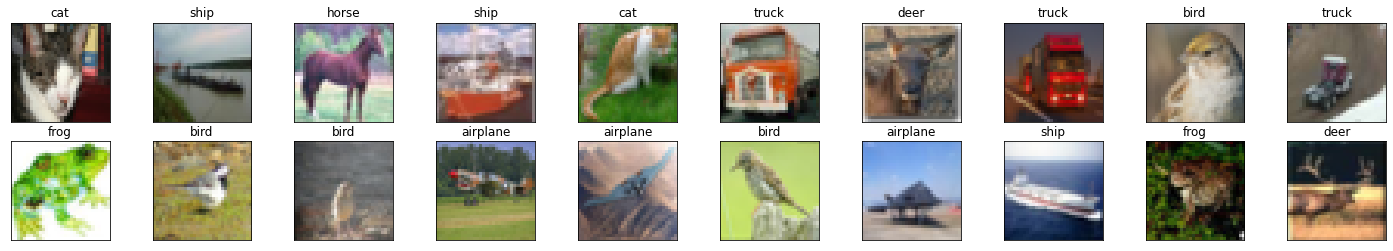

In [14]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(test_data[idx])
    ax.set_title(classes[test_targets[idx]])

In [15]:
!python --version

Python 3.7.7


## CNN training

In [16]:
import torch
import torch.nn as nn
from torch.nn import DataParallel
import time
import torch.optim as optim

from typing import Tuple, Any, List

def trainCls(model: nn.Module, train_loader: torch.utils.data.DataLoader, 
             val_loader: torch.utils.data.DataLoader, lr: float=0.1, epochs: int=100, 
             momentum: float=0.9, weight_decay: float=5e-4, 
             checkpoint: str='./checkpoint') -> Tuple[nn.Module, List, List, List, List]:
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device: {}'.format(device))
    
    model.to(device) # loading model to device

    if torch.cuda.device_count() > 1:
        if not isinstance(model, DataParallel):
            model = DataParallel(model) # if more that one gpu is available,
                                        # then wrap model with DataParallel,
                                        # so that it can be trained on multiple gpus
    
    model.to(device) # load model to device

    criterion = nn.CrossEntropyLoss() # loss-function for classification
    
    # optimizer is used to optime the model parameters while doing back-propagation
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    start = time.time()
    best_acc = 0.0
    
    trainLoss_, valLoss_ = list(), list()
    trainAcc_, valAcc_ = list(), list()
    
    start_epoch = 0

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for _, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            model.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            train_acc += predicted.eq(target).sum().item()
        
        train_loss, train_acc = train_loss/len(train_loader.sampler), train_acc/len(train_loader.sampler)
        trainLoss_.append(train_loss)
        trainAcc_.append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        for _, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            val_acc += predicted.eq(target).sum().item()
        
        val_loss, val_acc = val_loss/len(val_loader.sampler), val_acc/len(val_loader.sampler)
        valLoss_.append(val_loss)
        valAcc_.append(val_acc)

        if val_acc > best_acc:
            print('Epoch: {} val accuracy improved: {:0.4f} ==> {:0.4f}'.format(epoch+1, best_acc, val_acc))
            best_acc = val_acc

            try:
                state_dict = model.state_dict()
            except:
                state_dict = model.module.state_dict()

            torch.save(state_dict, checkpoint)

        print('Epoch: [{}/{}] train_acc: {:0.4f} val_acc: {:0.4f} train_loss: {:0.4f} val_loss: {:0.4f}'.format(epoch+1, epochs, train_acc, val_acc, train_loss, val_loss))

    total_time = time.time() - start
    print('time: {:0.0f}m {:0.0f}s'.format((total_time//60), (total_time%60)))
    
    # loading model's best saved weight
    try:
        model.load_state_dict(torch.load(checkpoint, map_location=device))
    except:
        model.module.load_state_dict(torch.load(checkpoint, map_location=device))

    return model, trainLoss_, valLoss_, trainAcc_, valAcc_

# ResNet-18

In [17]:
from resnet import ResNet18

model = ResNet18(num_classes=10)
print(model)

data = torch.randn(10, 3, 32, 32)
with torch.no_grad():
    output = model(data)
print('data.shape: {} output.shape: {}'.format(data.size(), output.size()))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [19]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='tinyresnet18_cifar10_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.5153
Epoch: [1/100] train_acc: 0.4113 val_acc: 0.5153 train_loss: 1.6186 val_loss: 1.4016
Epoch: 2 val accuracy improved: 0.5153 ==> 0.6084
Epoch: [2/100] train_acc: 0.5032 val_acc: 0.6084 train_loss: 1.3888 val_loss: 1.1415
Epoch: [3/100] train_acc: 0.5576 val_acc: 0.5132 train_loss: 1.2341 val_loss: 1.6462
Epoch: 4 val accuracy improved: 0.6084 ==> 0.6907
Epoch: [4/100] train_acc: 0.6012 val_acc: 0.6907 train_loss: 1.1245 val_loss: 0.9112
Epoch: [5/100] train_acc: 0.6257 val_acc: 0.6907 train_loss: 1.0570 val_loss: 0.9506
Epoch: 6 val accuracy improved: 0.6907 ==> 0.7047
Epoch: [6/100] train_acc: 0.6470 val_acc: 0.7047 train_loss: 0.9977 val_loss: 0.8747
Epoch: 7 val accuracy improved: 0.7047 ==> 0.7273
Epoch: [7/100] train_acc: 0.6666 val_acc: 0.7273 train_loss: 0.9469 val_loss: 0.8042
Epoch: 8 val accuracy improved: 0.7273 ==> 0.7721
Epoch: [8/100] train_acc: 0.6808 val_acc: 0.7721 train_loss: 0.9088 val_loss: 0.6703
Epoch

Epoch: [80/100] train_acc: 0.8656 val_acc: 0.9029 train_loss: 0.3859 val_loss: 0.3266
Epoch: [81/100] train_acc: 0.8658 val_acc: 0.8822 train_loss: 0.3891 val_loss: 0.4106
Epoch: [82/100] train_acc: 0.8659 val_acc: 0.8895 train_loss: 0.3855 val_loss: 0.3720
Epoch: [83/100] train_acc: 0.8684 val_acc: 0.9020 train_loss: 0.3774 val_loss: 0.3281
Epoch: [84/100] train_acc: 0.8677 val_acc: 0.8930 train_loss: 0.3802 val_loss: 0.3558
Epoch: [85/100] train_acc: 0.8678 val_acc: 0.8999 train_loss: 0.3765 val_loss: 0.3363
Epoch: [86/100] train_acc: 0.8678 val_acc: 0.8755 train_loss: 0.3818 val_loss: 0.4485
Epoch: [87/100] train_acc: 0.8664 val_acc: 0.8877 train_loss: 0.3828 val_loss: 0.3992
Epoch: [88/100] train_acc: 0.8688 val_acc: 0.9005 train_loss: 0.3776 val_loss: 0.3443
Epoch: [89/100] train_acc: 0.8698 val_acc: 0.8915 train_loss: 0.3716 val_loss: 0.3792
Epoch: [90/100] train_acc: 0.8726 val_acc: 0.8974 train_loss: 0.3676 val_loss: 0.3549
Epoch: 91 val accuracy improved: 0.9029 ==> 0.9051
Epo

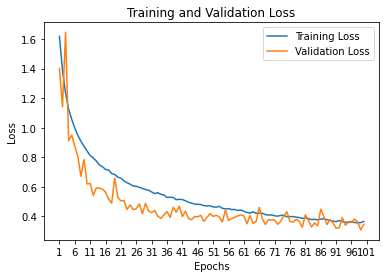

In [20]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

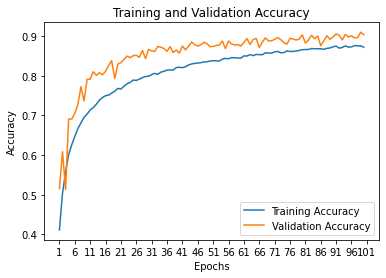

In [21]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

---
## Test the Trained Network


In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

model.to(device) # loading model to device

if torch.cuda.device_count() > 1:
    if not isinstance(model, DataParallel):
        model = DataParallel(model) # if more that one gpu is available,
                                    # then wrap model with DataParallel,
                                    # so that it can be trained on multiple gpus

model.to(device) # load model to device

device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [23]:
# loading model's best saved weight
checkpoint = 'tinyresnet18_cifar10_best_model.pth'

try:
    model.load_state_dict(torch.load(checkpoint, map_location=device))
except:
    model.module.load_state_dict(torch.load(checkpoint, map_location=device))

In [24]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

criterion = nn.CrossEntropyLoss()

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    batch_size = min(64, data.size(0))
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:0.4f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.3354

Test Accuracy of airplane: 91% (914/1000)
Test Accuracy of automobile: 94% (947/1000)
Test Accuracy of  bird: 84% (845/1000)
Test Accuracy of   cat: 85% (852/1000)
Test Accuracy of  deer: 90% (909/1000)
Test Accuracy of   dog: 80% (801/1000)
Test Accuracy of  frog: 94% (946/1000)
Test Accuracy of horse: 93% (933/1000)
Test Accuracy of  ship: 91% (919/1000)
Test Accuracy of truck: 95% (950/1000)

Test Accuracy (Overall): 90% (9016/10000)


### Visualize Sample Test Results

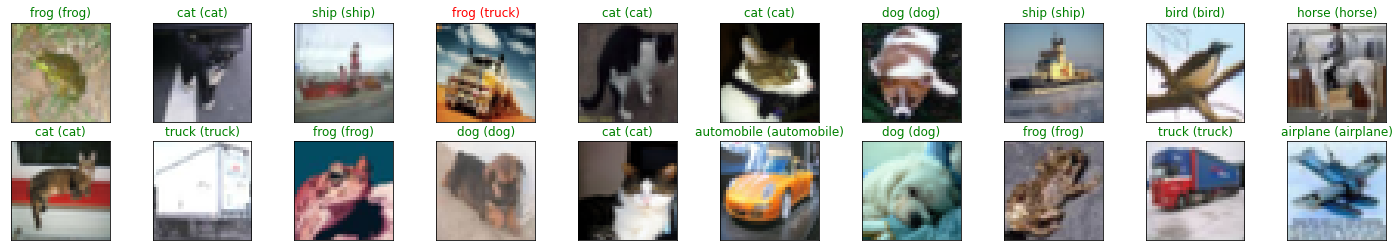

In [25]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not torch.cuda.is_available() else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# ResNet-50

In [26]:
from resnet import ResNet50

model = ResNet50(num_classes=10)
print(model)

data = torch.randn(10, 3, 32, 32)
with torch.no_grad():
    output = model(data)
print('data.shape: {} output.shape: {}'.format(data.size(), output.size()))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

data.shape: torch.Size([10, 3, 32, 32]) output.shape: torch.Size([10, 10])


In [27]:
# momentum, weight-decay will be discussed in the later classes

model, train_loss, val_loss, train_acc, val_acc = trainCls(model, train_loader, val_loader, 
                                                           lr=0.002, epochs=100, momentum=0.9, 
                                        weight_decay=5e-4, checkpoint='tinyresnet50_cifar10_best_model.pth')

device: cuda:0
Epoch: 1 val accuracy improved: 0.0000 ==> 0.4370
Epoch: [1/100] train_acc: 0.2912 val_acc: 0.4370 train_loss: 1.9699 val_loss: 1.5357
Epoch: 2 val accuracy improved: 0.4370 ==> 0.4901
Epoch: [2/100] train_acc: 0.3968 val_acc: 0.4901 train_loss: 1.6660 val_loss: 1.4402
Epoch: 3 val accuracy improved: 0.4901 ==> 0.5015
Epoch: [3/100] train_acc: 0.4503 val_acc: 0.5015 train_loss: 1.5322 val_loss: 1.4284
Epoch: 4 val accuracy improved: 0.5015 ==> 0.5311
Epoch: [4/100] train_acc: 0.4921 val_acc: 0.5311 train_loss: 1.4185 val_loss: 1.3503
Epoch: 5 val accuracy improved: 0.5311 ==> 0.6105
Epoch: [5/100] train_acc: 0.5320 val_acc: 0.6105 train_loss: 1.3111 val_loss: 1.1273
Epoch: 6 val accuracy improved: 0.6105 ==> 0.6417
Epoch: [6/100] train_acc: 0.5647 val_acc: 0.6417 train_loss: 1.2236 val_loss: 1.0150
Epoch: 7 val accuracy improved: 0.6417 ==> 0.6484
Epoch: [7/100] train_acc: 0.5937 val_acc: 0.6484 train_loss: 1.1546 val_loss: 1.0288
Epoch: 8 val accuracy improved: 0.6484 =

Epoch: [78/100] train_acc: 0.8626 val_acc: 0.9007 train_loss: 0.3933 val_loss: 0.3349
Epoch: [79/100] train_acc: 0.8659 val_acc: 0.9017 train_loss: 0.3890 val_loss: 0.3441
Epoch: [80/100] train_acc: 0.8654 val_acc: 0.9031 train_loss: 0.3834 val_loss: 0.3346
Epoch: [81/100] train_acc: 0.8647 val_acc: 0.8978 train_loss: 0.3872 val_loss: 0.3502
Epoch: [82/100] train_acc: 0.8667 val_acc: 0.9016 train_loss: 0.3797 val_loss: 0.3533
Epoch: [83/100] train_acc: 0.8650 val_acc: 0.8950 train_loss: 0.3895 val_loss: 0.3682
Epoch: [84/100] train_acc: 0.8669 val_acc: 0.8905 train_loss: 0.3844 val_loss: 0.4115
Epoch: 85 val accuracy improved: 0.9064 ==> 0.9106
Epoch: [85/100] train_acc: 0.8680 val_acc: 0.9106 train_loss: 0.3793 val_loss: 0.3016
Epoch: [86/100] train_acc: 0.8675 val_acc: 0.9006 train_loss: 0.3771 val_loss: 0.3461
Epoch: [87/100] train_acc: 0.8669 val_acc: 0.9022 train_loss: 0.3769 val_loss: 0.3207
Epoch: [88/100] train_acc: 0.8718 val_acc: 0.9063 train_loss: 0.3714 val_loss: 0.3356
Epo

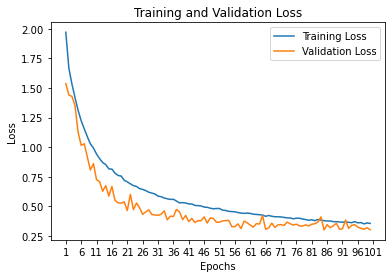

In [28]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

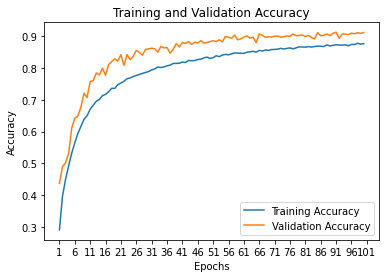

In [29]:
epochs = list(range(1, 101, 1))

# Plot and label the training and validation loss values
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
plt.xticks(np.arange(1, 105, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

---
## Test the Trained Network


In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))

model.to(device) # loading model to device

if torch.cuda.device_count() > 1:
    if not isinstance(model, DataParallel):
        model = DataParallel(model) # if more that one gpu is available,
                                    # then wrap model with DataParallel,
                                    # so that it can be trained on multiple gpus

model.to(device) # load model to device

device: cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [31]:
# loading model's best saved weight
checkpoint = 'tinyresnet50_cifar10_best_model.pth'

try:
    model.load_state_dict(torch.load(checkpoint, map_location=device))
except:
    model.module.load_state_dict(torch.load(checkpoint, map_location=device))

In [32]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

criterion = nn.CrossEntropyLoss()

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    batch_size = min(64, data.size(0))
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:0.4f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.3296

Test Accuracy of airplane: 89% (891/1000)
Test Accuracy of automobile: 97% (972/1000)
Test Accuracy of  bird: 91% (912/1000)
Test Accuracy of   cat: 83% (836/1000)
Test Accuracy of  deer: 89% (899/1000)
Test Accuracy of   dog: 80% (809/1000)
Test Accuracy of  frog: 92% (926/1000)
Test Accuracy of horse: 93% (933/1000)
Test Accuracy of  ship: 95% (955/1000)
Test Accuracy of truck: 92% (928/1000)

Test Accuracy (Overall): 90% (9061/10000)


### Visualize Sample Test Results

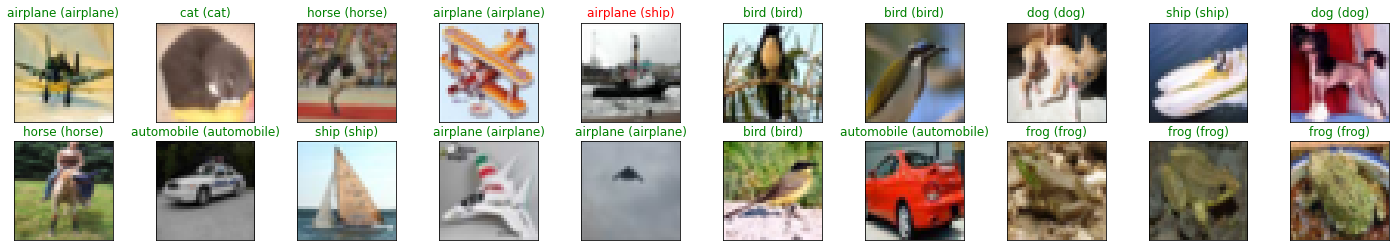

In [33]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not torch.cuda.is_available() else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))